<font color="red"><h1>OpenSees Examples Manual using OpenSeesPy!</h1></font>
<h2><u>OpenSees Example 2a</u></h2>
<h2>Elastic Portal Frame -- Dynamic Lateral Load Analysis</h2>

You can find the original OpenSees examples manual using Tcl [here](https://opensees.berkeley.edu/wiki/index.php/Examples_Manual). (Original Examples in Tcl by Silvia Mazzoni & Frank McKenna, 2006.)

<h2><u>Simulation Process</u></h2>

In the following example, an input file (python script) is created to conduct a simulation in OpenSees. The process of creating the input file is broken-down into the following parts:

<h3>A. Build the model</h3>
<ol>
    <li>model dimensions and degrees-of-freedom</li>
    <li>nodal coordinates</li>
    <li>nodal constraints -- boundary conditions</li>
    <li>nodal masses</li>
    <li>elements and element connectivity</li>
    <li>recorders for output</li>
</ol>
<h3>B. Define & apply gravity load</h3>
<ol>
    <li>nodal or element load</li>
    <li>static-analysis parameters (tolerances & load increments)</li>
    <li>analyze</li>
    <li>hold gravity loads constant</li>
    <li>reset time to zero</li>
</ol>
<h3>C. Define and apply lateral load</h3>
<dl>
<li>Time Series and Load Pattern (nodal loads for static analysis, support ground motion for earthquake)</li>
<li>lateral-analysis parameters (tolerances and displacement/time increments)</li>
<b>Static Lateral-Load Analysis</b>
<li>define the displacement increments and displacement path</li>
<b>Dynamic Lateral-Load Analysis</b>
<li>define the input motion and all associated parameters, such as scaling and input type</li>
<li>define analysis duration and time increment</li>
<li>define damping</li>
<li>analyze</li>
<p>    
    
<b>Introductory Examples</b>
The objective is to give an overview of input-file format in OpenSees using simple scripts.


<b> Example 2a introduces the use of</b>
- Two element types <br>
- Distributed element loads <br>

<img src="https://opensees.berkeley.edu/wiki/images/d/d5/Example1b_EQ.GIF">


In [69]:
# Import required modules
import openseespy.opensees as ops  # OpenSeesPy: The Python interface for OpenSees, used for finite element analysis.
import opsvis as opsv  # Visualization tool for OpenSees models.
import os  # Provides functions for interacting with the operating system.
import numpy as np # Python library used for scientific computing
import matplotlib.pyplot as plt  # Plotting library for data visualization.

In [70]:
# Check if a directory named 'Data' exists; if not, create one.
# This directory will store any data or results generated during the simulation.
if not os.path.exists('Data'): 
    os.mkdir('Data')

## Units

In [71]:
# Defining base units for the simulation.
m = 1.0  # Meter (base unit for length)
s = 1.0  # Second (base unit for time)
kg = 1.0  # Kilogram (base unit for mass)

# Derived units for force and pressure.
N = kg * m / s ** 2  # Newton (unit of force)
Pa = N / m ** 2  # Pascal (unit of pressure)

# Additional conversions for different units commonly used in structural engineering.
inches = 0.0254 * m  # Conversion factor for inches to meters.
ft = 12 * inches  # Conversion factor for feet to meters.
kip = 4448.2216152548 * N  # Conversion factor for kips (1000 pounds-force) to Newtons.
ksi = 6.895 * 10 ** 6 * Pa  # Conversion factor for ksi (1000 psi) to Pascals.

## Input Variables

In [72]:
beam_length = 42.0 * ft
column_length = 36.0 * ft

# Nodal coordinates
n1 = (0.0, 0.0) # Use floating point values
n2 = (beam_length, 0.0)
n3 = (0.0, column_length)
n4 = (beam_length, column_length)


# Cross-sectional dimensions
# Beam
bBeam = 5 * ft # Breadth
dBeam = 8 * ft # Depth
ABeam = bBeam * dBeam # Area
# Columns
bCol = 5 * ft # Breadth
dCol = 5 * ft # Depth
ACol = bCol * dCol # Area


# Elastic Modulus
E = 4227 * ksi

# Moment of Inertia
IzBeam = (bBeam * dBeam ** 3) / 12 # Beam
IzCol = (bCol * dCol ** 3) / 12 # Column


# Loads/Actions
Py = -4000.0 * kip # Gravity load
w = Py / beam_length # Uniformly distributed load (N/m)


In [73]:
g = 9.81 # Gravitational acceleration (N / kg)

# Nodal mass
mass_x = abs(Py) / (2 * g) # kg
print(f'The nodal mass value corresponding to the horizontal DOF is {mass_x:.2f} kg. This is equivalent to {mass_x / 175126.8352:.2f} kips * s^2 per inch') # 
massValues = [mass_x, 1 * 10 ** -9, 0.0] # ndf nodal mass values corresponding to each DOF

The nodal mass value corresponding to the horizontal DOF is 906874.95 kg. This is equivalent to 5.18 kips * s^2 per inch


## Model definition

Text(0.5, 1.0, 'plot_model after defining nodes')

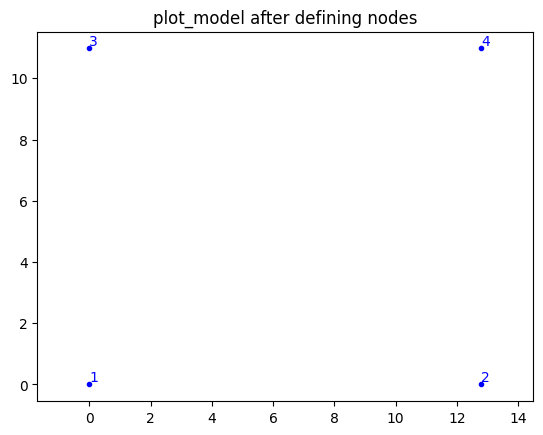

In [74]:
ops.wipe() # Clear opensees model
ops.model('basic','-ndm',2,'-ndf',3)     #  # 2D model with 3 degrees of freedom per node.

# define GEOMETRY -------------------------------------------------------------

# Create nodes
nodal_crds = (n1, n2, n3, n4)
for nodeTag, crds in enumerate(nodal_crds, start = 1): # https://docs.python.org/3/library/functions.html#enumerate
    ops.node(nodeTag, *crds)


# Plot Model
opsv.plot_model()
plt.title('plot_model after defining nodes')

In [75]:
# Single point constraints -- Boundary Conditions
fully_fixed = [1, 1, 1]
free = [0, 0, 0]

ops.fix(1, *fully_fixed)     #  node DX DY RZ
ops.fix(2, *fully_fixed)     #  node DX DY RZ
ops.fix(3, *free)
ops.fix(4, *free)

# nodal masses:
ops.mass(3,mass_x,0.,0.)     #  node , Mx My Mz, Mass=Weight/g.
ops.mass(4,mass_x,0.,0.)

# Define ELEMENTS -------------------------------------------------------------
# define geometric transformation: performs a linear geometric transformation of beam stiffness and resisting force from the basic system to the global-coordinate system
ops.geomTransf('Linear',1)     #  associate a tag to transformation

# connectivity: (make A very large, 10e6 times its actual value)
ops.element('elasticBeamColumn',1,1,3, ACol * 10 ** 6, E, IzCol, 1)     #  element elasticBeamColumn eleTag iNode jNode A E Iz transfTag
ops.element('elasticBeamColumn',2,2,4, ACol * 10 ** 6, E, IzCol, 1)
ops.element('elasticBeamColumn',3,3,4, ABeam * 10 ** 6, E, IzBeam, 1)

Text(0.5, 1.0, 'plot_model after defining elements')

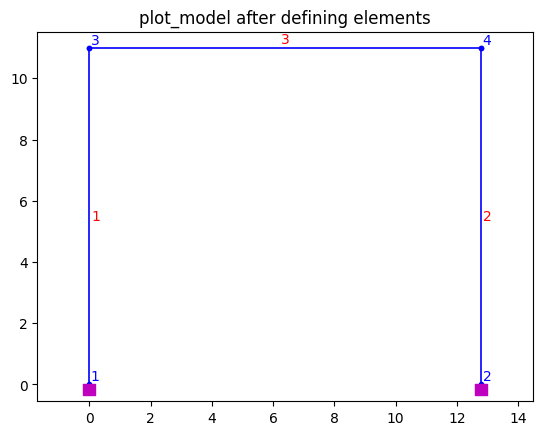

In [76]:
# Plot Model
opsv.plot_model()
plt.title('plot_model after defining elements')

In [77]:
# Define RECORDERS -------------------------------------------------------------
ops.recorder('Node','-file','Data/DispFreeEx2aEQ.out','-time','-node',3,4,'-dof',1,2,3,'disp')     #  displacements of free nodes
ops.recorder('Node','-file','Data/DispBaseEx2aEQ.out','-time','-node',1,2,'-dof',1,2,3,'disp')     #  displacements of support nodes
ops.recorder('Node','-file','Data/RBaseEx2aEQ.out','-time','-node',1,2,'-dof',1,2,3,'reaction')     #  support reaction
ops.recorder('Element','-file','Data/FColEx2aEQ.out','-time','-ele',1,2,'globalForce')     #  element forces -- column
ops.recorder('Element','-file','Data/FBeamEx2aEQ.out','-time','-ele',3,'globalForce')     #  element forces -- beam

24

## Loads and Analysis

### Load definition (Gravity Loads)

In [78]:
# define GRAVITY -------------------------------------------------------------
ops.timeSeries('Linear',1)     # timeSeries Linear 1;
# define Load Pattern
ops.pattern('Plain',1,1) # 
ops.eleLoad('-ele',3,'-type','-beamUniform', w)     # w distributed superstructure-weight on beam


### Analysis generation (Gravity loads)

In [79]:
ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.constraints('Plain')     #  how it handles boundary conditions
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.test('NormDispIncr',1.0e-8,6)     #  determine if convergence has been achieved at the end of an iteration step
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.integrator('LoadControl',0.1)     #  determine the next time step for an analysis,   apply gravity in 10 steps
ops.analysis('Static')     #  define type of analysis static or transient
ops.analyze(10)     #  perform gravity analysis
ops.loadConst('-time',0.0)     #  hold gravity constant and restart time

print(f'The distributed superstructure-weight on the beam is {w:0.2f} N/m. This is equivalent to {w * 5.710144071 * 10 ** -6:0.2f} kips/inch')

The distributed superstructure-weight on the beam is -1389895.52 N/m. This is equivalent to -7.94 kips/inch


Text(0.5, 1.0, 'Deformed shape of portal frame after gravity loads have been applied (Scale factor: 100)')

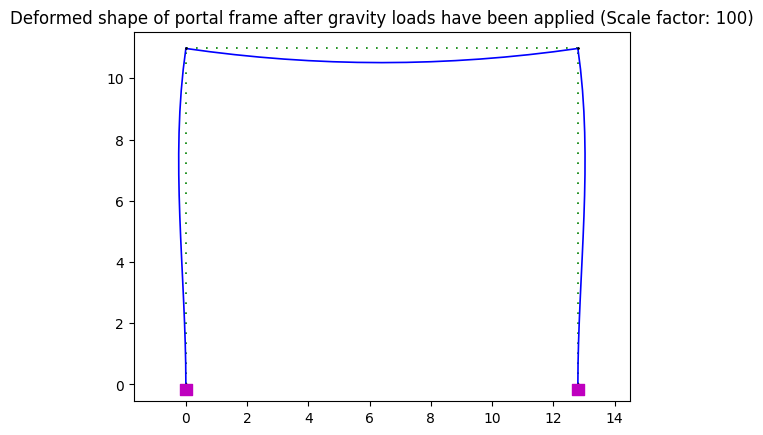

In [80]:
sfac = opsv.plot_defo(sfac = 100)
plt.title(f'Deformed shape of portal frame after gravity loads have been applied (Scale factor: {sfac})')

### Load definition (Lateral loads)

In [81]:
# DYNAMIC ground-motion analysis -------------------------------------------------------------
# create load pattern
accelSeries  = 900
ops.timeSeries('Path',accelSeries,'-dt',0.01,'-filePath','BM68elc.acc','-factor',1)     #  define acceleration vector from file (dt=0.01 is associated with the input file gm)
ops.pattern('UniformExcitation',2,1,'-accel',accelSeries)     #  define where and how (pattern tag, dof) acceleration is applied
ops.rayleigh(0.,0.,0.,2*0.02/np.pow(ops.eigen('-fullGenLapack',1)[0],0.5))     #  set


### Analysis generation (Lateral loads)

In [82]:
# create the analysis
ops.wipeAnalysis()     #  clear previously-define analysis parameters
# ops.wipeAnalysis()     # adding this to clear Analysis module 
ops.constraints('Plain')     #  how it handles boundary conditions
ops.numberer('Plain')     #  renumber dofs to minimize band-width (optimization), if you want to
ops.system('BandGeneral')     #  how to store and solve the system of equations in the analysis
ops.test('NormDispIncr',1.0e-8,10)     #  determine if convergence has been achieved at the end of an iteration step
ops.algorithm('Newton')     #  use Newtons solution algorithm: updates tangent stiffness at every iteration
ops.integrator('Newmark',0.5,0.25)     #  determine the next time step for an analysis
ops.analysis('Transient')     #  define type of analysis: time-dependent
ops.analyze(1000,0.02)     #  apply 1000 0.02-sec time steps in analysis

0

## Output

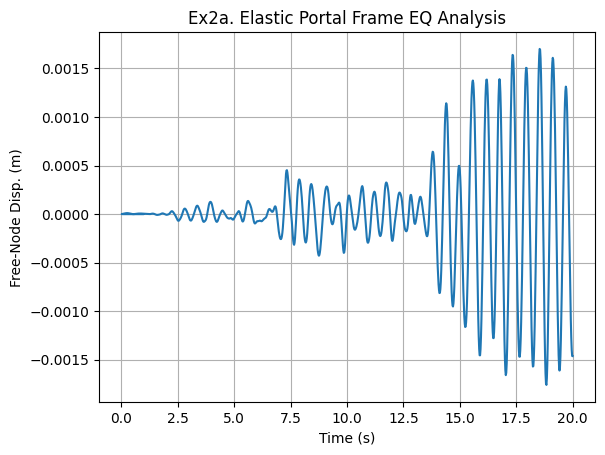

End of Run


In [83]:
ops.wipe()
plt.close('all')

# Load the data
fname3 = 'Data/DispFreeEx2aEQ.out'
dataDFree = np.loadtxt(fname3)

# Create a figure and axes instances
fig, ax = plt.subplots(1, 1)

# Plot on the first axis
ax.set_title('Ex2a. Elastic Portal Frame EQ Analysis')
ax.grid(True)
ax.plot(dataDFree[:, 0], dataDFree[:, 1])
ax.set_xlabel('Time (s)')
ax.set_ylabel('Free-Node Disp. (m)')

plt.show()

# End of script
print('End of Run')